Realizacion del ajuste exponenial mediante np.curvefit, obteniendo los parametros V_0 y tau correspondientes al modelo de carga.

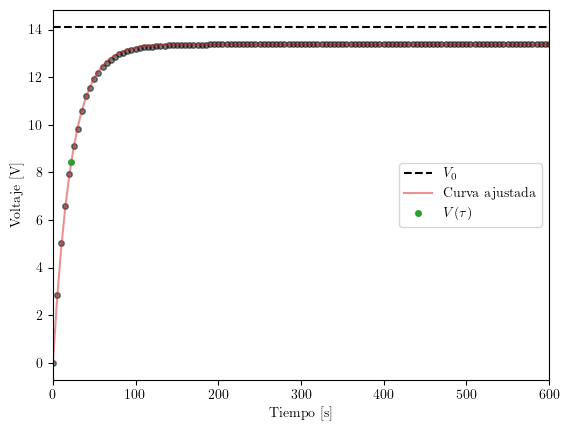

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp


plt.rcParams['text.usetex'] = True

# Generaciond de datos

df1 = pd.read_excel(r"F:\Facultad\Laboratorios\EyM\Lab2\datos.xlsx", sheet_name="datos",
                    usecols="B", skiprows=range(2), nrows=121, header=None)

tiempoCarga = np.arange(0, 605, 5)
voltajeCarga = df1.to_numpy().flatten().transpose()


# Ajuste exponencial
def modeloCarga(x, v0, tau):
    return v0 * (1 - np.exp(-(1/tau) * x))

params, pcov = sp.optimize.curve_fit(modeloCarga, tiempoCarga, voltajeCarga) # Coeficientes
v0Ajuste, tauCargaAjuste = params

pesoTauCarga = 1/pcov[1][1]

incertidumbre = np.sqrt(np.diag(pcov)) # Calculo la desv stnd con la matriz de covarianza
incertidumbreV0, incertidumbreTau = incertidumbre


# Voltaje en funcion de tau

vTau = modeloCarga(tauCargaAjuste, v0Ajuste, tauCargaAjuste) # Esto corresponderia al 63,2% de la carga

# Graficacion

if __name__ == "__main__":

    fix, ax = plt.subplots()

    # Utilizar fuente de Latex
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'

    ax.hlines(14.12, 0, 600, colors="black", ls="--", label="$V_{0}$")
    ax.plot(tiempoCarga, voltajeCarga, "o", color="black", markersize=4, alpha=0.5)
    ax.plot(tiempoCarga, modeloCarga(tiempoCarga, v0Ajuste, tauCargaAjuste), '-', color="tab:red", markersize=4, alpha=0.5, label="Curva ajustada")
    ax.plot(tauCargaAjuste, vTau, "o", color="tab:green", markersize=4, label =r"$V(\tau)$")

    plt.xlim(0, 600)
    ax.legend(loc="center right")
    ax.set_xlabel("Tiempo [s]")
    ax.set_ylabel("Voltaje [V]")
    
plt.show()


Realización del ajuste exponenial mediante np.curvefit, obteniendo los parametros V_0 y tau correspondientes al modelo de descarga.

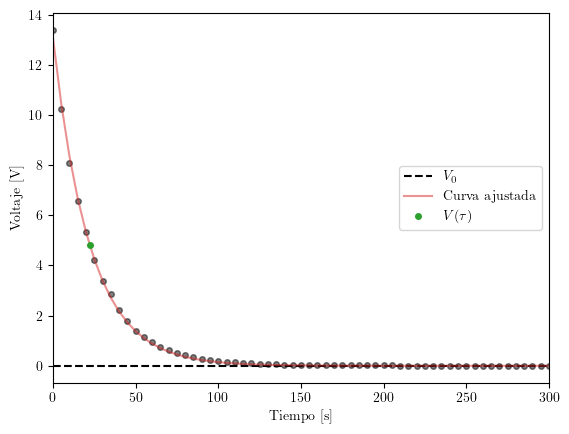

In [35]:

df1 = pd.read_excel(r"F:\Facultad\Laboratorios\EyM\Lab2\datos.xlsx", sheet_name="datos",
                    usecols="D", skiprows=range(2), nrows=61, header=None)

voltajeDescarga = df1.to_numpy().flatten().transpose()
tiempoDescarga = np.arange(0, 305, 5)


# Ajuste exponencial
def modeloDescarga(x, v0, tau):
    return v0*np.exp(-x*(1/tau))

params, pcov = sp.optimize.curve_fit(modeloDescarga, tiempoDescarga, voltajeDescarga) # Coeficientes
v0Ajuste, tauDescargaAjuste = params
pesoTauDescarga = 1/pcov[1][1]
incertidumbre = np.sqrt(np.diag(pcov)) # Calculo la desv stnd con la matriz de covarianza
incertidumbreV0, incertidumbreTau = incertidumbre


# Voltaje en funcion de tau

vTau = modeloDescarga(tauDescargaAjuste, v0Ajuste, tauDescargaAjuste)

# Graficacion

fix, ax = plt.subplots()

# Utilizar fuente de Latex
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

ax.hlines(0, 0, 300, colors="black", ls="--", label="$V_0$")
ax.plot(tiempoDescarga, voltajeDescarga, "o", color="black", markersize=4, alpha=0.5)
ax.plot(tiempoDescarga, modeloDescarga(tiempoDescarga, v0Ajuste, tauDescargaAjuste), '-', color="tab:red", markersize=4, alpha=0.5, label="Curva ajustada")
ax.plot(tauDescargaAjuste, vTau, "o", color="tab:green", markersize=4, label =r"$V(\tau)$")
plt.xlim(0, 300)

ax.legend(loc="center right")
ax.set_xlabel("Tiempo [s]")
ax.set_ylabel("Voltaje [V]")


plt.show()

Obtencion de la media ponderada de tau

In [36]:
tau = np.array([tauCargaAjuste, tauDescargaAjuste])
pesos = np.array([pesoTauCarga, pesoTauDescarga])

def mediaPon(x, w):
    return (x*w).sum()/w.sum()

def devPon(w):
    return np.sqrt(1/w.sum())

mediaTau = mediaPon(tau, pesos)
incertPon = devPon(pesos)
print("media =",mediaTau, "incerteza =",incertPon)

media = 22.250891032362198 incerteza = 0.05313523006299384


Obtención del valor de la capacitancia C

In [37]:
R = 46400 #ohm
C = mediaTau / R
print(C)

0.0004795450653526336
